# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

c:\Users\Kirill\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magic.py:187: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


Wall time: 244 ms
Wall time: 11 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [3]:
# params, gradients указатели на параметры в списке
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [4]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [5]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 23.546025695601394


### Модель

In [8]:
model = Sequential(
    Linear(10, 8),
    LeakyReLU(),
    Dropout(p=0.2),
    Linear(8, 1)
    
    
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

In [10]:
model

### Обучение

In [11]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
15.775105069385447
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
14.829219678849611
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
5.667174070162714
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
35.319875411252
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
1053.7773832829278
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
821353621.4615319
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
1.227398451432193e+24
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
9.176596273124322e+71
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
1.7238939937258591e+214
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
inf
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (

<ipython-input-2-26456431c236>:4: RuntimeWarning: overflow encountered in power
  output = np.sum(np.power(input - target, 2)) / batch_size
<ipython-input-2-66fca11048ac>:26: RuntimeWarning: invalid value encountered in multiply
  grad_input = ( grad_output * self.mask ) / self.p


mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10, 8)
nan
mask (10, 8) grad (10, 8)
mask (10, 8) grad (10,

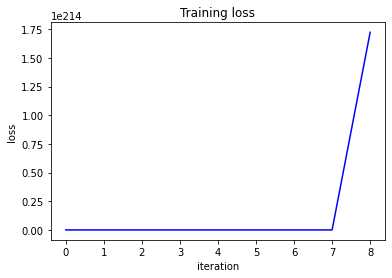

In [12]:
history = []

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        print(loss)

        itog_ = model.forward(X_test)
        loss_test = criterion.forward(y_pred, y_true)
        
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

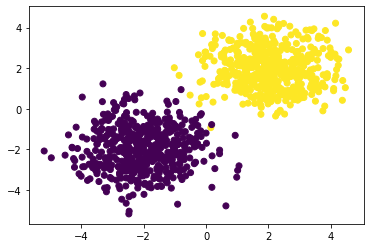

In [12]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [13]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [14]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

In [15]:
# history = []

# for i in range(epochs):
#     for x, y_true in loader(X, Y, batch_size):
#         # forward: считаем все значения до функции потерь
#         y_pred = model.forward(x)
#         loss = criterion.forward(y_pred, y_true)
    
#         # backward: считаем все градиенты в обратном порядке
#         grad = criterion.backward(y_pred, y_true)
#         model.backward(x, grad)
        
#         # обновляем веса
#         SGD(model.parameters(),
#             model.grad_parameters(),
#             learning_rate)
        
#         # логгируем лосс
#         history.append(loss)

    
# plt.title("Training loss")
# plt.xlabel("iteration")
# plt.ylabel("loss")
# plt.plot(history, 'b')
# plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

In [16]:
y_true

array([[-2.78322641],
       [-1.88738838],
       [ 2.34060195],
       [-3.28170029],
       [ 6.16333134],
       [ 0.87485126],
       [ 4.78661622],
       [-2.13462408],
       [-4.32881844],
       [ 0.76183241]])

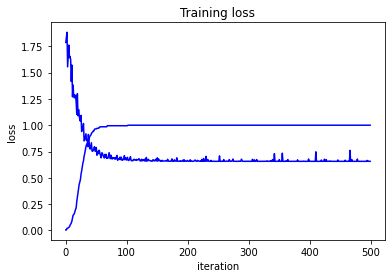

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
history = []
accuracy_test = []
for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        history.append(loss)

        
        y_pred_test = model.forward(X_test)
        y_pred_test_ = np.argmax(y_pred_test, axis=1)
        accuracy_test.append(accuracy_score(y_pred_test_, y_test[:, 1]))



    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(accuracy_test, 'b')
plt.plot(history, 'b')
plt.show()

In [18]:
history

[1.786318703521299,
 1.8385010029522146,
 1.883232778868274,
 1.5541613729278616,
 1.6573388771753834,
 1.7617551013481776,
 1.6421437254436193,
 1.653212322612339,
 1.6232396703991845,
 1.415431351985557,
 1.5712162478470246,
 1.2697306774237291,
 1.382241501128398,
 1.2666246628551523,
 1.2879736606302603,
 1.2582673790201404,
 1.284300793252322,
 1.2216763226093146,
 1.1032229945156873,
 1.2992721753144298,
 1.089252305150156,
 1.1484297712054663,
 1.0981181820899955,
 1.043741137896263,
 1.0415488895170009,
 1.0928318559598307,
 0.9397090784527977,
 0.9816104542717563,
 0.9604109083065582,
 1.0160023063262569,
 0.8509056520590377,
 0.8584740609334169,
 0.8867417834305384,
 0.9186755633691089,
 0.8584452390555937,
 0.863906558905055,
 0.7969832641972039,
 0.9120219449181316,
 0.8566882699095649,
 0.7829197657538315,
 0.7729788289901411,
 0.8051451349879304,
 0.8332018077845824,
 0.754967531346317,
 0.7521127713846346,
 0.7617097323972885,
 0.7768334214962195,
 0.7953397666276026,
 0

In [19]:
y_pred_test

array([[5.31988715e-07, 2.68941278e-01],
       [2.52451621e-12, 2.68941421e-01],
       [3.90201475e-12, 2.68941421e-01],
       [5.09825821e-09, 2.68941420e-01],
       [2.68940950e-01, 1.75415436e-06],
       [1.29361616e-08, 2.68941418e-01],
       [6.18252637e-12, 2.68941421e-01],
       [1.32061504e-11, 2.68941421e-01],
       [6.32902117e-06, 2.68939719e-01],
       [2.68941421e-01, 1.17767801e-12],
       [7.90600745e-03, 2.66783350e-01],
       [2.68941421e-01, 1.25842935e-12],
       [8.25910968e-16, 2.68941421e-01],
       [3.41557765e-11, 2.68941421e-01],
       [3.83196747e-17, 2.68941421e-01],
       [2.18322343e-11, 2.68941421e-01],
       [2.68941421e-01, 2.28313231e-14],
       [3.53289020e-07, 2.68941326e-01],
       [1.80435437e-09, 2.68941421e-01],
       [2.68941421e-01, 1.70206862e-18],
       [8.18493415e-10, 2.68941421e-01],
       [2.58121999e-01, 3.73865266e-02],
       [2.68941035e-01, 1.43608107e-06],
       [1.06293071e-10, 2.68941421e-01],
       [2.689414

# Теперь сами

In [21]:
# # !pip uninstall scikit-learn
# !pip install scikit-learn==0.23.1
# !pip uninstall scikit-learn

In [24]:
import os
from sklearn.datasets import fetch_openml
# Как я загружаю данные
# Описание: https://github.com/ageron/handson-ml/issues/301#issuecomment-448853256


# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz') and 1 > 2:
    with np.load('mnist.npz', 'r') as data:
        mnist = data
        # X = data['X']
        # y = data['y']
        X = mnist.data / 255.0
        y = mnist.target
else:
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [25]:
# pd.DataFrame(y).get_damies()
y = pd.get_dummies(y)

Разделите датасет на train и validation.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.1, random_state=42)

In [27]:
1e-2

0.01

0 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.39183673469387753 %
0.5224489795918368 %
0.6530612244897959 %
0.7836734693877551 %
0.9142857142857143 %
1 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.39183673469387753 %
0.5224489795918368 %
0.6530612244897959 %
0.7836734693877551 %
0.9142857142857143 %
2 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.39183673469387753 %
0.5224489795918368 %
0.6530612244897959 %
0.7836734693877551 %
0.9142857142857143 %
3 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.39183673469387753 %
0.5224489795918368 %
0.6530612244897959 %
0.7836734693877551 %
0.9142857142857143 %
4 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.39183673469387753 %
0.5224489795918368 %
0.6530612244897959 %
0.7836734693877551 %
0.9142857142857143 %
5 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.39183673469387753 %
0.5224489795918368 %
0.6530612244897959 %
0.7836734693877551 %
0.9142857142857143 %
6 Эпоха
0.1306122448979592 %
0.2612244897959184 %
0.391836734693

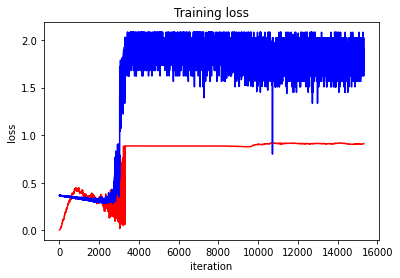

In [38]:
epochs = 10
batch_size = 2**5
learning_rate = 1e-2

model = Sequential(
    Linear(784, 128),
    ReLU(),
    Linear(128, 10),
    SoftMax()
)

criterion = CrossEntropy()

history = []
accuracy_test = []
for i in range(epochs):
    print(i, 'Эпоха')
    s = 0
    for x, y_true in loader(X_train, y_train, batch_size):
        s += 1
        if s % 200 == 0:
            print((s * batch_size) / X_train.shape[0], '%') 
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        history.append(loss)

        
        y_pred_test = model.forward(X_test)
        y_pred_test_ = np.argmax(y_pred_test, axis=1)
        accuracy_test.append(accuracy_score(y_pred_test_, y_test[:, 1]))



    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(accuracy_test, 'r')
plt.plot(history, 'b')
plt.show()

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [39]:
accuracy_test[-200:]

[0.906952380952381,
 0.9070476190476191,
 0.9065714285714286,
 0.9064761904761904,
 0.906952380952381,
 0.9069047619047619,
 0.9071904761904762,
 0.9071904761904762,
 0.9079047619047619,
 0.9074761904761904,
 0.907952380952381,
 0.9077619047619048,
 0.9078571428571428,
 0.9072380952380953,
 0.9072380952380953,
 0.9070952380952381,
 0.9072380952380953,
 0.906952380952381,
 0.906952380952381,
 0.906952380952381,
 0.9067142857142857,
 0.9064761904761904,
 0.9063809523809524,
 0.9062857142857143,
 0.9064285714285715,
 0.9061904761904762,
 0.9060952380952381,
 0.9060476190476191,
 0.9061428571428571,
 0.9064761904761904,
 0.9065714285714286,
 0.9064761904761904,
 0.9062857142857143,
 0.9064285714285715,
 0.9063809523809524,
 0.9066666666666666,
 0.9067619047619048,
 0.9064761904761904,
 0.9065714285714286,
 0.9061904761904762,
 0.9060952380952381,
 0.9058571428571428,
 0.906,
 0.9057142857142857,
 0.906,
 0.9061428571428571,
 0.9065714285714286,
 0.9068095238095238,
 0.9068571428571428,
 0.

In [ ]:
# ...